In [1]:
import tensorflow as tf
#import tensorflow_hub as hub
# import requests
print("TensorFlow version: {}".format(tf.__version__))
import zipfile
# import requests
import os
import time
import pandas as pd
import random
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, AvgPool2D, Dense, Concatenate, Flatten, Lambda, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
import numpy as np
from PIL import Image
import tensorflow.keras.backend as K
import pickle
from tensorflow.keras.models import load_model, Model

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except:
        print("Couldn't set memory_growth")
        pass
    
    
def fix_random_seed(seed):
    """ Setting the random seed of various libraries """
    try:
        np.random.seed(seed)
    except NameError:
        print("Warning: Numpy is not imported. Setting the seed for Numpy failed.")
    try:
        tf.random.set_seed(seed)
    except NameError:
        print("Warning: TensorFlow is not imported. Setting the seed for TensorFlow failed.")
    try:
        random.seed(seed)
    except NameError:
        print("Warning: random module is not imported. Setting the seed for random failed.")

# Fixing the random seed
random_seed=4321
fix_random_seed(random_seed)

TensorFlow version: 2.16.2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import os
import requests
import zipfile

# Retrieve the data
if not os.path.exists(os.path.join('data','tiny-imagenet-200.zip')):
    url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    # Get the file from web
    r = requests.get(url)

    if not os.path.exists('data'):
        os.mkdir('data')
    
    # Write to a file
    with open(os.path.join('data','tiny-imagenet-200.zip'), 'wb') as f:
        f.write(r.content)
else:
    print("The zip file already exists.")
    
if not os.path.exists(os.path.join('data', 'tiny-imagenet-200')):
    with zipfile.ZipFile(os.path.join('data','tiny-imagenet-200.zip'), 'r') as zip_ref:
        zip_ref.extractall('data')
else:
    print("The extracted data already exists")

The zip file already exists.
The extracted data already exists


In [3]:
from functools import partial

def get_test_labels_df(test_labels_path):
    """ Reading the test data labels for all files in the test set as a data frame """
    test_df = pd.read_csv(test_labels_path, sep='\t', index_col=None, header=None)
    test_df = test_df.iloc[:,[0,1]].rename({0:"filename", 1:"class"}, axis=1)
    return test_df
        

def get_train_valid_test_data_generators(batch_size, target_size):
    """ Get the training/validation/testing data generators """
    
    # Code listing 7.1
    # Defining a data-augmenting image data generator and a standard image data generator
    image_gen_aug = ImageDataGenerator(
        samplewise_center=False, rotation_range=30, width_shift_range=0.2,
        height_shift_range=0.2, brightness_range=(0.5,1.5), shear_range=5, 
        zoom_range=0.2, horizontal_flip=True, fill_mode='reflect', validation_split=0.1
    )
    image_gen = ImageDataGenerator(samplewise_center=False)
    
    # Code listing 7.2
    # Define a training data generator
    partial_flow_func = partial(
        image_gen_aug.flow_from_directory, 
        directory=os.path.join('data','tiny-imagenet-200', 'train'), 
        target_size=target_size, classes=None,
        class_mode='categorical', batch_size=batch_size, 
        shuffle=True, seed=random_seed)
    
    # Get the training data subset
    train_gen = partial_flow_func(subset='training')
    # Get the validation data subset
    valid_gen = partial_flow_func(subset='validation')    

    # Defining the test data generator
    test_df = get_test_labels_df(os.path.join('data','tiny-imagenet-200',  'val', 'val_annotations.txt'))
    test_gen = image_gen.flow_from_dataframe(
        test_df, directory=os.path.join('data','tiny-imagenet-200',  'val', 'images'), target_size=target_size, classes=None,
        class_mode='categorical', batch_size=batch_size, shuffle=False
    )
    return train_gen, valid_gen, test_gen

# Code listing 7.3
def data_gen_augmented_inceptionnet_v1(gen, random_gamma=False, random_occlude=False):
    for x,y in gen: 
        
        if x.ndim != 4:
            raise ValueError("This function is designed for a batch of images with 4 dims [b, h, w, c]")
            
        if random_gamma:
            # Gamma correction
            # Doing this in the image process fn doesn't help improve performance
            rand_gamma = np.random.uniform(0.9, 1.08, (x.shape[0],1,1,1))
            x = x**rand_gamma
        
        if random_occlude:
            # Randomly occluding sections in the image
            occ_size = 10
            occ_h, occ_w = np.random.randint(0, x.shape[1]-occ_size), np.random.randint(0, x.shape[2]-occ_size)
            x[::2,occ_h:occ_h+occ_size,occ_w:occ_w+occ_size,:] = np.random.choice([0.,128.,255.])
        
        # Image centering
        x -= np.mean(x, axis=(1,2,3), keepdims=True)
        
        # Making sure we replicate the target (y) three times
        yield x,(y,y,y)
        
batch_size = 128
target_size = (56,56)
# Getting the train,valid, test data generators
train_gen, valid_gen, test_gen = get_train_valid_test_data_generators(batch_size, target_size)
# Modifying the data generators to fit the model targets
# We augment data in the training set
train_gen_aux = data_gen_augmented_inceptionnet_v1(train_gen, random_gamma=True, random_occlude=True)
# We do not augment data in the validation/test datasets
valid_gen_aux = data_gen_augmented_inceptionnet_v1(valid_gen)
test_gen_aux = data_gen_augmented_inceptionnet_v1(test_gen)

Found 90000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Found 10000 validated image filenames belonging to 200 classes.


In [5]:
from itertools import tee
all_labels = []
n_trials = 10

valid_gen_test = tee(valid_gen, n_trials)

for i in range(n_trials):    
    labels = []
    for j in range(5):
        _, ohe = next(valid_gen_test[i])
        # Convert one hot encoded to class labels
        labels.append(np.argmax(ohe, axis=-1))
        
    # Concat all labels
    labels = np.reshape(np.concatenate(labels, axis=0), (1,-1))        
    all_labels.append(labels)

# Concat all labels accross all trials
all_labels = np.concatenate(all_labels, axis=0)

# Assert the labels are equal across all trials
assert np.all(np.all(all_labels == all_labels[0,:], axis=0)), "Labels across multiple trials were not equal"
print("Successful! Labels across all trials were consistent.")

Successful! Labels across all trials were consistent.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [73..328].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [24..262].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [28..283].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [70..264].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [39..294].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5..195].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [19..274].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats 

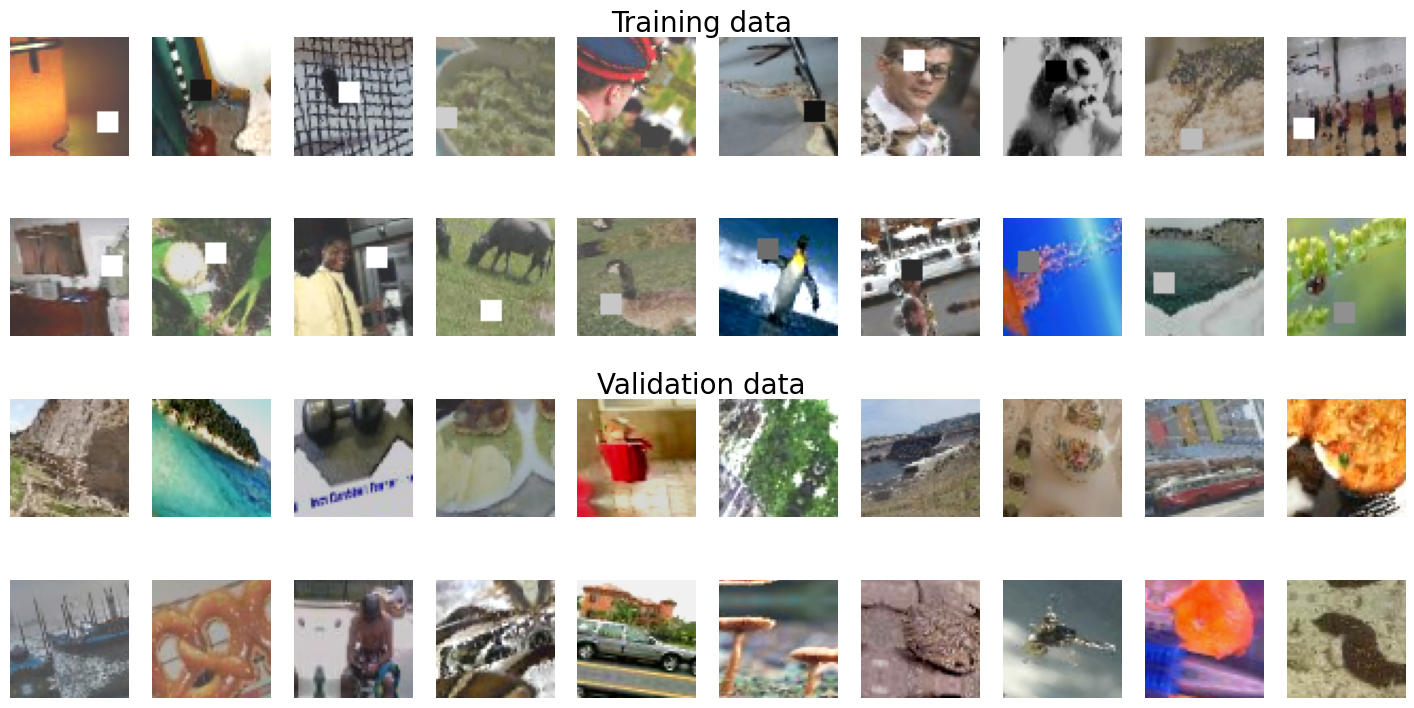

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

data = [] # Holds both training and validation samples to be plotted

# Getting training samples (20 samples)
for i, (x,y) in enumerate(train_gen_aux):
    if i>=20: break
    data.append((x[0,:,:,:]+128).astype('int32'))
    
# Getting validation samples (20 samples)
for i,(x,y) in enumerate(valid_gen_aux):
    if i>=20: break
    data.append((x[0,:,:,:]+128).astype('int32'))
    
# Creating a plot with 40 subplots (4 rows and 10 columns)
n_rows = 4
n_cols = 10
f, axes = plt.subplots(n_rows, n_cols, figsize=(18,9))

# Plot the training and validation images
# First 2 rows are training data
# Second 2 rows are validation data
for ri in range(n_rows):
    for ci in range(n_cols):
        # Plotting the correct image at ri,ci position in the plot
        i = ri*n_cols + ci
        axes[ri][ci].imshow(data[i])
        axes[ri][ci].axis('off')
        
        # Setting plot titles
        if ri==0 and ci == n_cols//2:
            axes[ri][ci].set_title("Training data", fontsize=20, pad=1, x=-0.15)
        elif ri==2 and ci == n_cols/2:
            axes[ri][ci].set_title("Validation data", fontsize=20, pad=1, x=-0.15)

In [7]:
def data_gen_augmented_minception(gen, random_gamma=False, random_occlude=False):
    for x,y in gen: 
        if x.ndim != 4:
            raise ValueError("This function is designed for a batch of images with 4 dims [b, h, w, c]")
            
        if random_gamma:
            # Gamma correction
            # Doing this in the image process fn doesn't help improve performance
            rand_gamma = np.random.uniform(0.93, 1.06, (x.shape[0],1,1,1))
            x = x**rand_gamma
        
        if random_occlude:
            # Randomly occluding sections in the image
            occ_size = 10
            occ_h, occ_w = np.random.randint(0, x.shape[1]-occ_size), np.random.randint(0, x.shape[2]-occ_size)
            x[::2,occ_h:occ_h+occ_size,occ_w:occ_w+occ_size,:] = np.random.choice([0.,128.,255.])
        
        # Making sure we replicate the target (y) three times
        yield x,y
        
        
batch_size = 128
target_size = (64,64)
# Getting the train,valid, test data generators
train_gen, valid_gen, test_gen = get_train_valid_test_data_generators(batch_size, target_size)
# Modifying the data generators to fit the model targets
# We augment data in the training set
train_gen_aux = data_gen_augmented_minception(train_gen, random_gamma=True, random_occlude=True)
# We do not augment data in the validation/test datasets
valid_gen_aux = data_gen_augmented_minception(valid_gen)
test_gen_aux = data_gen_augmented_minception(test_gen)

Found 90000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Found 10000 validated image filenames belonging to 200 classes.


In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dropout, AvgPool2D, Dense, Concatenate, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import RandomCrop, RandomContrast
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger

K.clear_session()
def get_minception_resnet_v2():

    def stem(inp, activation='relu', bn=True):
    
        conv1_1 = Conv2D(32, (3,3), strides=(2,2), activation=None, kernel_initializer=init, padding='same')(inp) #62x62
        if bn:
            conv1_1 = BatchNormalization()(conv1_1)
        conv1_1 = Activation(activation)(conv1_1)
        
        conv1_2 = Conv2D(32, (3,3), strides=(1,1), activation=None, kernel_initializer=init, padding='same')(conv1_1) # 31x31
        if bn:
            conv1_2 = BatchNormalization()(conv1_2)
        conv1_2 = Activation(activation)(conv1_2)
        
        conv1_3 = Conv2D(64, (3,3), strides=(1,1), activation=None, kernel_initializer=init, padding='same')(conv1_2) # 31x31
        if bn:
            conv1_3 = BatchNormalization()(conv1_3)
        conv1_3 = Activation(activation)(conv1_3)
        
        # Split to two branches
        # Branch 1
        maxpool2_1 = MaxPool2D((3,3), strides=(2,2), padding='same')(conv1_3)
        
        # Branch 2
        conv2_2 = Conv2D(96, (3,3), strides=(2,2), activation=None, kernel_initializer=init, padding='same')(conv1_3)
        if bn:
            conv2_2 = BatchNormalization()(conv2_2)
        conv2_2 = Activation(activation)(conv2_2)
        
        # Concat the results from two branches
        out2 = Concatenate(axis=-1)([maxpool2_1, conv2_2])
        
        # Split to two branches
        # Branch 1
        conv3_1 = Conv2D(64, (1,1), strides=(1,1), activation=None, kernel_initializer=init, padding='same')(out2)
        if bn:
            conv3_1 = BatchNormalization()(conv3_1)
        conv3_1 = Activation(activation)(conv3_1)
        
        conv3_2 = Conv2D(96, (3,3), strides=(1,1), activation=None, kernel_initializer=init, padding='same')(conv3_1)
        if bn:
            conv3_2 = BatchNormalization()(conv3_2)
        conv3_2 = Activation(activation)(conv3_2)
        
        # Branch 2
        conv4_1 = Conv2D(64, (1,1), strides=(1,1), activation=None, kernel_initializer=init, padding='same')(out2)
        if bn:
            conv4_1 = BatchNormalization()(conv4_1)
        conv4_1 = Activation(activation)(conv4_1)
        
        conv4_2 = Conv2D(64, (7,1), strides=(1,1), activation=None, kernel_initializer=init, padding='same')(conv4_1)
        if bn:
            conv4_2 = BatchNormalization()(conv4_2)
        
        conv4_3 = Conv2D(64, (1,7), strides=(1,1), activation=None, kernel_initializer=init, padding='same')(conv4_2)
        if bn:
            conv4_3 = BatchNormalization()(conv4_3)
        conv4_3 = Activation(activation)(conv4_3)
        
        conv4_4 = Conv2D(96, (3,3), strides=(1,1), activation=None, kernel_initializer=init, padding='same')(conv4_3)
        if bn:
            conv4_4 = BatchNormalization()(conv4_4)
        conv4_4 = Activation(activation)(conv4_4)
        
        # Concat the results from two branches
        out34 = Concatenate(axis=-1)([conv3_2, conv4_4])
        
        # Split to two branches
        # Branch 1
        maxpool5_1 = MaxPool2D((3,3), strides=(2,2), padding='same')(out34)
        # Branch 2
        conv6_1 = Conv2D(192, (3,3), strides=(2,2), activation=None, kernel_initializer=init, padding='same')(out34)
        if bn:
            conv6_1 = BatchNormalization()(conv6_1)
        conv6_1 = Activation(activation)(conv6_1)
        
        # Concat the results from two branches
        out56 = Concatenate(axis=-1)([maxpool5_1, conv6_1])
        
        return out56
    def inception_resnet_a(inp, n_filters, initializer, activation='relu', bn=True, res_w=0.1):
        
        # Split to three branches
        # Branch 1
        out1_1 = Conv2D(n_filters[0][0], (1,1), strides=(1,1), activation=None, 
                        kernel_initializer=initializer, padding='same')(inp)
        if bn:
            out1_1 = BatchNormalization()(out1_1)
        out1_1 = Activation(activation)(out1_1)
            
        # Branch 2
        out2_1 = Conv2D(n_filters[1][0], (1,1), strides=(1,1), activation=None, 
                        kernel_initializer=initializer, padding='same')(inp)
        if bn:
            out2_1 = BatchNormalization()(out2_1)
        out2_1 = Activation(activation)(out2_1)
        
        out2_2 = Conv2D(n_filters[1][1], (1,1), strides=(1,1), activation=None, 
                        kernel_initializer=initializer, padding='same')(out2_1)
        if bn:
            out2_2 = BatchNormalization()(out2_2)
        out2_2 = Activation(activation)(out2_2)
        
        # Branch 3
        out3_1 = Conv2D(n_filters[2][0], (1,1), strides=(1,1), activation=None, 
                        kernel_initializer=initializer, padding='same')(inp)
        if bn:
            out3_1 = BatchNormalization()(out3_1)
        out3_1 = Activation(activation)(out3_1)
        
        out3_2 = Conv2D(n_filters[2][1], (3,3), strides=(1,1), activation=None, 
                        kernel_initializer=initializer, padding='same')(out3_1)
        if bn:
            out3_2 = BatchNormalization()(out3_2)
        out3_2 = Activation(activation)(out3_2)
        
        out3_3 = Conv2D(n_filters[2][2], (3,3), strides=(1,1), activation=None, 
                        kernel_initializer=initializer, padding='same')(out3_2)
        if bn:
            out3_3 = BatchNormalization()(out3_3)
        out3_3 = Activation(activation)(out3_3)
        
        out3_4 = Conv2D(n_filters[2][3], (1,1), strides=(1,1), activation=None, 
                        kernel_initializer=initializer, padding='same')(out3_3)
        if bn:
            out3_4 = BatchNormalization()(out3_4)
        out3_4 = Activation(activation)(out3_4)
        
        # Concat the results from three branches
        out4_1 = Concatenate(axis=-1)([out1_1, out2_2, out3_4])
        out4_2 = Conv2D(n_filters[3][0], (1,1), strides=(1,1), activation=None, 
                        kernel_initializer=initializer, padding='same')(out4_1)
        if bn:
            out4_2 = BatchNormalization()(out4_2)
        
        # Residual connection
        out4_2 += res_w * inp
        
        # Last activation
        out4_2 = Activation(activation)(out4_2)
        
        return out4_2
    
    def inception_resnet_b(inp, n_filters, initializer, activation='relu', bn=True, res_w=0.1):
        
        # Split to two branches
        # Branch 1
        out1_1 = Conv2D(n_filters[0][0], (1,1), strides=(1,1), activation=None, 
                        kernel_initializer=initializer, padding='same')(inp)
        if bn:
            out1_1 = BatchNormalization()(out1_1)
        out1_1 = Activation(activation)(out1_1)
        
        # Branch 2
        out2_1 = Conv2D(n_filters[1][0], (1,1), strides=(1,1), activation=activation, 
                        kernel_initializer=initializer, padding='same')(inp)
        if bn:
            out2_1 = BatchNormalization()(out2_1)
        out2_1 = Activation(activation)(out2_1)
        
        out2_2 = Conv2D(n_filters[1][1], (1,7), strides=(1,1), activation=None, 
                        kernel_initializer=initializer, padding='same')(out2_1)
        if bn:
            out2_2 = BatchNormalization()(out2_2)
        out2_2 = Activation(activation)(out2_2)
        
        out2_3 = Conv2D(n_filters[1][2], (7,1), strides=(1,1), activation=None, 
                        kernel_initializer=initializer, padding='same')(out2_2)
        if bn:
            out2_3 = BatchNormalization()(out2_3)
        out2_3 = Activation(activation)(out2_3)
        
        # Concat the results from 2 branches
        out3_1 = Concatenate(axis=-1)([out1_1, out2_3])
        out3_2 = Conv2D(n_filters[2][0], (1,1), strides=(1,1), activation=None, 
                        kernel_initializer=initializer, padding='same')(out3_1)
        if bn:
            out3_2 = BatchNormalization()(out3_2)
        
        # Residual connection
        out3_2 += res_w * inp
        
        # Last activation
        out3_2 = Activation(activation)(out3_2)
        
        return out3_2
    
    def reduction(inp, n_filters, initializer, activation='relu', bn=True):
        # Split to three branches
        # Branch 1
        out1_1 = Conv2D(n_filters[0][0], (3,3), strides=(2,2), activation=activation, 
                        kernel_initializer=initializer, padding='same')(inp)
        if bn:
            out1_1 = BatchNormalization()(out1_1)
        out1_2 = Conv2D(n_filters[0][1], (3,3), strides=(1,1), activation=activation, 
                        kernel_initializer=initializer, padding='same')(out1_1)
        if bn:
            out1_2 = BatchNormalization()(out1_2)
        out1_3 = Conv2D(n_filters[0][2], (3,3), strides=(1,1), activation=activation, 
                        kernel_initializer=initializer, padding='same')(out1_2)
        if bn:
            out1_3 = BatchNormalization()(out1_3)
        
        # Branch 2
        out2_1 = Conv2D(n_filters[1][0], (3,3), strides=(2,2), activation=activation, 
                        kernel_initializer=initializer, padding='same')(inp)
        if bn:
            out2_1 = BatchNormalization()(out2_1)
        
        # Branch 3
        out3_1 = MaxPool2D((3,3), strides=(2,2), padding='same')(inp)
        
        # Concat the results from 3 branches
        out = Concatenate(axis=-1)([out1_3, out2_1, out3_1])        

        return out
    
    
    activation=tf.nn.leaky_relu
    init = tf.keras.initializers.GlorotUniform() #tf.keras.initializers.VarianceScaling(scale=2.0, mode='fan_in')
    
    bn=True
    
    
    inp = Input(shape=(64,64,3))
    crop_inp = RandomCrop(56, 56, seed=random_seed)(inp)
    crop_inp = RandomContrast(0.3, seed=random_seed)(crop_inp)
    stem_out = stem(crop_inp)
    
    inc_a = inception_resnet_a(stem_out, [(32,),(32,32), (32, 48, 64, 384),(384,)], initializer=init)    

    red = reduction(inc_a, [(256,256,384),(384,)], initializer=init)

    inc_b1 = inception_resnet_b(red, [(192,),(128,160,192),(1152,)], initializer=init)
    inc_b2 = inception_resnet_b(inc_b1,  [(192,),(128,160,192),(1152,)], initializer=init)    
    
    avgpool1 = AvgPool2D((4,4), strides=(1,1), padding='valid')(inc_b2)
    flat_out = Flatten()(avgpool1)
    dropout1 = Dropout(0.5)(flat_out)
    out_main = Dense(200, activation='softmax',  kernel_initializer=init, name='final')(flat_out)

    # Loss Weighing: https://github.com/tensorflow/models/blob/09d3c74a31d7e0c1742ae65025c249609b3c9d81/research/slim/train_image_classifier.py#L495
    minception_resnet_v2 = Model(inputs=inp, outputs=out_main)
    
    minception_resnet_v2.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])
    
    return minception_resnet_v2

model = get_minception_resnet_v2()
model.summary()

2024-10-07 18:46:02.988656: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-10-07 18:46:02.988677: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-10-07 18:46:02.988685: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-10-07 18:46:02.988718: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-07 18:46:02.988728: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_crop         │ (None, 56, 56, 3) │          0 │ input_layer[0][0] │
│ (RandomCrop)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_contrast     │ (None, 56, 56, 3) │          0 │ random_crop[0][0] │
│ (RandomContrast)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28,    │        896 │ random_contrast[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 28, 28,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │     18,496 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 14, 14,    │     55,392 │ activation_2[0][… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        384 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 14, 14,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 14, 14,    │          0 │ max_pooling2d[0]

 Total params: 7,169,784 (27.35 MB)

 Trainable params: 7,156,184 (27.30 MB)

 Non-trainable params: 13,600 (53.12 KB)

In [10]:
import time
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
from functools import partial

def get_steps_per_epoch(n_data, batch_size):
    """ Given the data size and batch size, gives the number of steps to travers the full dataset """
    if n_data%batch_size==0:
        return int(n_data/batch_size)
    else:
        return int(n_data*1.0/batch_size)+1
    
es_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger(os.path.join('eval','3_eval_minception.log'))
n_epochs=5

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(    
    monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='auto'
)

t1 = time.time()
history = model.fit(
    train_gen_aux, validation_data=valid_gen_aux, 
    steps_per_epoch=get_steps_per_epoch(int(0.9*(500*200)),batch_size), 
    validation_steps=get_steps_per_epoch(int(0.1*(500*200)),batch_size),
    epochs=n_epochs , callable = [es_callback , csv_logger]
)
t2 = time.time()

print("It took {} seconds to complete the training".format(t2-t1))

Epoch 1/5
  9/704 ━━━━━━━━━━━━━━━━━━━━ 3:49 330ms/step - accuracy: 0.2176 - loss: 3.3220

KeyboardInterrupt: 